## In this Notebook
* examples of applications of ADI 


In [1]:
using Random
using LinearAlgebra
using SparseArrays
using Plots
using Statistics

┌ Info: Recompiling stale cache file /home/jane/.julia/compiled/v1.2/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1240


### Dynamical Systems
Given $x,u,y$ as state, input, and output vectors, we can work with the simple discrete-time linear system representing

$$\dot{x}=A x+B u, \quad y=C x$$

An example is a balance system. In this case, if $u$ is a horizontal vector

$$A = \left[\begin{array}{ccccc}{0} & {1} & {0} & {\dots} & {0} \\ {0} & {0} & {1} & {\dots} & {0} \\ {\vdots} & {} & {} & {\ddots} & {} \\ {0} & {} & {} & {} & {1} \\ {-a_{n}} & {-a_{n-1}} & {\dots} & {} & {-a_{1}}\end{array}\right], B = \left[\begin{array}{c}{0} \\ {0} \\ {\vdots} \\ {0} \\ {1}\end{array}\right], C = \left[\begin{array}{llll}{b_{n}} & {b_{n-1}} & {\ldots} & {b_{1}}\end{array}\right]^T $$


This is based on the system on page 40 of [this systems modelling textbook](https://www.cds.caltech.edu/~murray/courses/cds101/fa04/caltech/am04_ch2-3oct04.pdf).

The Sylvester equation arises in the Sylvester controller equation, which is included in the Control Theory section below.

In [70]:
function gen_balance(n)
    A = zeros((n-1,n-1)) + I
    a = rand(n) .-1
    A = [zeros(n-1) A; a']
    B = zeros(n) 
    B[end] = 1
    C = rand(n)'
    return A,B,C
end

gen_balance (generic function with 1 method)

In [71]:
A,B,C = gen_balance(n)
display("text/plain",A)
display("text/plain",B)
display("text/plain",C)

10×10 Array{Float64,2}:
  0.0       1.0        0.0       …   0.0        0.0        0.0     
  0.0       0.0        1.0           0.0        0.0        0.0     
  0.0       0.0        0.0           0.0        0.0        0.0     
  0.0       0.0        0.0           0.0        0.0        0.0     
  0.0       0.0        0.0           0.0        0.0        0.0     
  0.0       0.0        0.0       …   0.0        0.0        0.0     
  0.0       0.0        0.0           1.0        0.0        0.0     
  0.0       0.0        0.0           0.0        1.0        0.0     
  0.0       0.0        0.0           0.0        0.0        1.0     
 -0.29199  -0.424337  -0.864311     -0.742518  -0.787097  -0.311314

10-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0

1×10 Adjoint{Float64,Array{Float64,1}}:
 0.128183  0.957515  0.5215  0.140495  …  0.99587  0.276688  0.00169009

### PDE

The example below is the 2D heat equation, or

$$u' = \alpha \nabla ^2 u$$

The boundary conditions are randomly generated in the function below.

In [135]:
function diffmat(N,k)
    if N == 0 D = []; return end
    if N == 1 D = 0; return end
    D = []
    
    x = chebpts(N);
    w = [.5 ; ones(N-1,1)]; w[2:2:end] .= -1; w[N] = .5*w[N];

    ii = diagind(zeros(N,N))
    Dx = broadcast(-,x,x');       # all pairwise differences
    Dx = Dx + I;            # add identity
    Dxi = 1 ./ Dx;                    # reciprocal 
    Dw = broadcast(/,w',w);    # pairwise divisions
    Dw = Dw - I;            # subtract identity

    D = Dw .* Dxi
    if k == 1
        D = Dw .* Dxi;
        D[ii] .= 0; D[ii] = -1 * sum(D, dims=2);              # negative sum trick
    elseif k == 2 
        D = 2*D .* (repeat(D[ii],1,N) - Dxi);
        D[ii] .= 0; D[ii] = -1 * sum(D, dims=2);              # negative sum trick
    else
        D = k*Dxi .* (Dw.*repeat(D[ii],1,N) - D);
        D[ii] .= 0; D[ii] = -1 * sum(D,dims=2);               # negative sum trick
    end
    
    return D
end

# Chebyshev points on an interval
# https://github.com/ay2718/spectral-pde-solver/blob/master/chebpts.jl
function chebpts(n, interval = [-1.0, 1.0])
    m = n-1;
    chpts = sin.(pi*(-m:2:m) ./ (2*m));
    chpts.*=(0.5*diff(interval));
    chpts.+=(0.5*sum(interval));
    chpts
end

chebpts (generic function with 2 methods)

In [136]:
diffmat(20,2)

20×20 Array{Float64,2}:
 -20352.5       21503.8       -1362.5       …     -1.01378        0.5     
   5375.94      -6454.75       1216.68             0.513923      -0.253445
   -340.626      1216.68      -1268.4             -0.535717       0.264117
     68.8393     -175.055       454.395            0.574491      -0.283092
    -22.4913       51.4191      -81.4744          -0.634436       0.3124  
      9.6018      -20.9358       27.7349    …      0.72262       -0.355458
     -4.87197      10.3582      -12.571           -0.850688       0.417877
      2.79354      -5.85079       6.75519          1.03804       -0.508971
     -1.75657       3.64367      -4.07777         -1.318          0.644648
      1.18813      -2.44851       2.68392          1.75034       -0.853258
     -0.853258      1.75034      -1.89107   …     -2.44851        1.18813 
      0.644648     -1.318         1.40924          3.64367       -1.75657 
     -0.508971      1.03804      -1.10145         -5.85079        2.79354 
 

In [142]:
function gen_2dheat(n)
    h = 1 / (n - 1) # resolution of the discretization
    innerA = diffmat(n-1, 2)
    A = [zeros(n-1) innerA zeros(n-1) ]
    A = vcat(A, zeros(n-1))
    A = vcat(zeros(n-1), A)
    tau = 0.2
    x = repeat([collect(1:1:n)],n)
    x = hcat(x...)
    y = x'
    C = log.(tau .+ abs.(x - y))
    
    return A,C
end

gen_2dheat (generic function with 1 method)

In [155]:
n=14
innerA = diffmat(n-1, 2)
A = [zeros(n-1) innerA zeros(n-1) ]
print(size(A))
A = [zeros(n)'; A ; zeros(n)' ]

(13, 15)

ArgumentError: ArgumentError: number of columns of each array must match (got (14, 15, 14))

In [148]:
b = ones(3,3)
[b zeros(3)]

3×4 Array{Float64,2}:
 1.0  1.0  1.0  0.0
 1.0  1.0  1.0  0.0
 1.0  1.0  1.0  0.0

In [143]:
A,C = gen_2dheat(10)
display("text/plain",A)
display("text/plain",C)

ArgumentError: ArgumentError: number of columns of each array must match (got (1, 9, 1))

### Control Theory

We look at the Sylvester-controller equation

$$TX - XA = -GC $$

The following code will generate an arbitrary $A$ and $B$ to frame the problem, a $T$ constructed based on a random spectrum $\Omega$, and $G$  chosen such that $(T,G)$ is controllable.

In [26]:
function state_estimation(n)
    A,B,C = gen_balance(n)
    evals = rand(n) .- 2
    T = zeros((n,n))
    T[diagind(T,0)] = evals
    T[diagind(T,-1)] .= 1
    G = zeros(n) 
    G[1] = 1
    return A,T,B,G
end

state_estimation (generic function with 1 method)

In [27]:
A,T,B,G = state_estimation(10)
display("text/plain",A)
display("text/plain",T)
display("text/plain",G)

10×10 Array{Float64,2}:
  0.0         1.0        0.0       …   0.0        0.0         0.0      
  0.0         0.0        1.0           0.0        0.0         0.0      
  0.0         0.0        0.0           0.0        0.0         0.0      
  0.0         0.0        0.0           0.0        0.0         0.0      
  0.0         0.0        0.0           0.0        0.0         0.0      
  0.0         0.0        0.0       …   0.0        0.0         0.0      
  0.0         0.0        0.0           1.0        0.0         0.0      
  0.0         0.0        0.0           0.0        1.0         0.0      
  0.0         0.0        0.0           0.0        0.0         1.0      
 -0.0564359  -0.263744  -0.865842     -0.477964  -0.0109068  -0.0981955

10×10 Array{Float64,2}:
 -1.15171   0.0       0.0       0.0      …   0.0       0.0       0.0    
  1.0      -1.75048   0.0       0.0          0.0       0.0       0.0    
  0.0       1.0      -1.80078   0.0          0.0       0.0       0.0    
  0.0       0.0       1.0      -1.55203      0.0       0.0       0.0    
  0.0       0.0       0.0       1.0          0.0       0.0       0.0    
  0.0       0.0       0.0       0.0      …   0.0       0.0       0.0    
  0.0       0.0       0.0       0.0          0.0       0.0       0.0    
  0.0       0.0       0.0       0.0         -1.34291   0.0       0.0    
  0.0       0.0       0.0       0.0          1.0      -1.16372   0.0    
  0.0       0.0       0.0       0.0          0.0       1.0      -1.72796

10-element Array{Float64,1}:
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

### Image Denoising
For this set of examples, the noisy image is generated from one of the Julia samples. The image can be changed to provide other examples.

$$\hat{F} \Phi_{x}+\sigma_{\eta}^{2} \Phi_{y}^{-1} \hat{F}=G \Phi_{x}$$

We create the distorted image $G$ by adding Gaussian noise. The approximation of the original image is $\hat F$.

In [29]:
using TestImages
using Images

┌ Info: Precompiling TestImages [5e47fb64-e119-507b-a336-dd2b206d9990]
└ @ Base loading.jl:1242
┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1242


ArgumentError: ArgumentError: Package ImageView not found in current path:
- Run `import Pkg; Pkg.add("ImageView")` to install the ImageView package.


In [64]:
function gen_imagedenoise(name)
    rng = MersenneTwister(1234);
    img = testimage(name)
    gimg = Gray.(img)
    mat = convert(Array{Float64}, gimg)
    
    n,m = size(gimg)
    eta = rand(1)[1] 
    noise = zeros((n,m))
    randn!(rng,noise)
    noise *= eta
    
    G = noise + mat
    
    covx = cov(vec(G'), vec(G'))
    covy = cov(vec(G), vec(G))
    coveta = cov(vec(noise), vec(noise))
    
    return G, covx, covy, coveta
end

gen_imagedenoise (generic function with 1 method)

In [66]:
G, covx, covy, coveta = gen_imagedenoise("lena_gray_16bit")

([0.6249036448199897 0.32271742450677565 … 0.39723145226474815 0.3771489016972023; -0.036839176458840384 -0.2569794630976741 … 0.25311189731164246 0.14585741374171463; … ; -0.01519911191650302 0.21842942078581618 … 0.2513598471532658 -0.0690640884123215; 0.1132127608955376 -0.042103195887322906 … -0.1146461855823188 0.6997630866326513], 0.17082374821275553, 0.17082374821275628, 0.140512766982294)

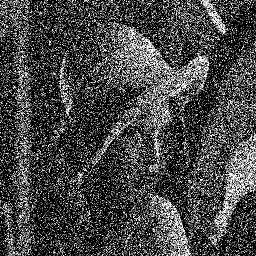

In [67]:
Gray.(G)